<hr color="#f0c6c6"/>
<h3><font color="#f0c6c6">Rules per metric</font></h3>

<font color="#a5adcb">
    We want to extract 10 rules per recipe by considering
</font>

- Confidence
- Lift
- Zhangs Metric

<hr color="#f0c6c6"/>

In [2]:
# add ../Example Gens to path
import sys
sys.path.append('../Example Gens')
import helper
DATA_DIR = '../dataset'

In [6]:
extracted_rules,extracted_ingredient_rules = helper.load_required_data_v2(DATA_DIR)

Starting to load rule data
Rule data loaded...

Starting rule extraction...
	 -> Starting to sort rules by lift
	 -> Done sorting rules...
______________________________


<hr color="#f0c6c6"/>
<h3><font color="#f0c6c6">RELEX Recipes</font></h3>

<hr color="#f0c6c6"/>

###

In [4]:
import pandas as pd

relex_recipes = pd.read_csv(f'{DATA_DIR}/relex_examples.csv')
print(relex_recipes.shape)

(187, 6)


In [5]:
from gensim.parsing.preprocessing import preprocess_string

relex_recipes['preprocessed'] = relex_recipes['recipe'].apply(preprocess_string)

In [6]:
# Crete a column called id which is the index of the dataframe
relex_recipes['id'] = relex_recipes.index
relex_recipes.head(2)

,user_id,event_date,event_type,details,recipe,ks-recipe,preprocessed,id
0,55ae64defdf99b3f864653e7,2022-09-04 03:28:18.613319,submit,{'recipe': 'Brown 1 pound of hamburger meat. D...,Brown 1 pound of hamburger meat. Drain the gre...,"[{'time': 1662261900176, 'character': 'Shift'}...","[brown, pound, hamburg, meat, drain, greas, ha...",0
1,55d22025cc2b18000c0b9d9c,2022-09-04 14:01:31.746981,submit,"{'recipe': ""To serve 4 people (your family!)\n...",To serve 4 people (your family!)\n\n\n-You wil...,"[{'time': 1662298866744, 'character': 'I'}, {'...","[serv, peopl, famili, need, knife, cut, board,...",1


In [7]:
from metric_testing import create_tasks, parallel_process
import os

metrics = ["lift", "confidence", "zhangs_metric"]
num_cpus = os.cpu_count() 
rule_count = 10

tasks = create_tasks(relex_recipes, metrics, num_cpus, extracted_rules, rule_count, helper.extract_rules)

In [10]:
from metric_testing import process_task
from tqdm import tqdm

results = []
for task in tqdm(tasks):
    metric, chunk, sorted_rules_df, rule_count, rule_extractor = task
    results.append(process_task(
        metric, chunk, sorted_rules_df, rule_count, rule_extractor
    ))

100%|██████████| 12/12 [1:38:51<00:00, 494.30s/it] 


In [18]:
relex_recipes.shape, relex_recipes.shape[0]*len(metrics)

((187, 8), 561)

In [15]:
# flatten the results list
flat_results = [item for sublist in results for item in sublist]
print(len(flat_results))

561


In [19]:
# save the results to a pkl file
import pickle
with open(f'{DATA_DIR}/relex_rules_per_metric.pkl', 'wb') as f:
    pickle.dump(flat_results, f)

<hr color="#f0c6c6"/>
<h3><font color="#f0c6c6">RecipeNLG Recipes</font></h3>

<hr color="#f0c6c6"/>

###

In [10]:
import pandas as pd
from gensim.parsing.preprocessing import preprocess_string

# sample random 100 recipes from the dataset under dataset/full_dataset.csv
seed = 1998
sample_recipes = pd.read_csv(f'{DATA_DIR}/full_dataset.csv').sample(1000, random_state=seed)
sample_recipes['directions'] = sample_recipes['directions'].apply(lambda x: eval(x))
# drop recipes that have directions with less than 125 characters in total
sample_recipes['directions_length'] = sample_recipes['directions'].apply(lambda x: len(' '.join(x)))
sample_recipes = sample_recipes[sample_recipes['directions_length'] > 125]

sample_recipes['preprocessed'] = sample_recipes['directions'].apply(lambda x: preprocess_string(' '.join(x)))

In [11]:
sample_recipes.head(2)

,Unnamed: 0,title,ingredients,directions,link,source,NER,directions_length,preprocessed
619506,619506,Baked Beans,"[""1 lb. ground beef"", ""1 small onion, chopped""...","[Brown ground beef and onion in heavy skillet,...",www.cookbooks.com/Recipe-Details.aspx?id=202520,Gathered,"[""ground beef"", ""onion"", ""salt"", ""pepper"", ""vi...",280,"[brown, ground, beef, onion, heavi, skillet, c..."
859178,859178,Tijuana Torte,"[""1 lb. ground beef"", ""1 medium onion, chopped...",[Brown ground beef and onion in skillet. Add s...,www.cookbooks.com/Recipe-Details.aspx?id=676449,Gathered,"[""ground beef"", ""onion"", ""tomatoes"", ""tomato s...",512,"[brown, ground, beef, onion, skillet, add, ste..."


In [9]:
# rename the unnamed: 0 column to id
sample_recipes.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
sample_recipes.head(2)

,id,title,ingredients,directions,link,source,NER,directions_length,preprocessed
619506,619506,Baked Beans,"[""1 lb. ground beef"", ""1 small onion, chopped""...","[Brown ground beef and onion in heavy skillet,...",www.cookbooks.com/Recipe-Details.aspx?id=202520,Gathered,"[""ground beef"", ""onion"", ""salt"", ""pepper"", ""vi...",280,"[brown, ground, beef, onion, heavi, skillet, c..."
859178,859178,Tijuana Torte,"[""1 lb. ground beef"", ""1 medium onion, chopped...",[Brown ground beef and onion in skillet. Add s...,www.cookbooks.com/Recipe-Details.aspx?id=676449,Gathered,"[""ground beef"", ""onion"", ""tomatoes"", ""tomato s...",512,"[brown, ground, beef, onion, skillet, add, ste..."


In [10]:
sample_recipes.shape

(892, 9)

In [11]:
from metric_testing import create_tasks, parallel_process

metrics = ["lift", "confidence", "zhangs_metric"]
num_cpus = 3
rule_count = 10

tasks = create_tasks(sample_recipes, metrics, num_cpus, extracted_rules, rule_count, helper.extract_rules)

In [12]:
sample_recipe_results = parallel_process(tasks, num_cpus)

In [ ]:
# save the results to a pkl file
import pickle
with open(f'{DATA_DIR}/sample_recipe_rules_per_metric.pkl', 'wb') as f:
    pickle.dump(sample_recipe_results, f)

<hr color="#f0c6c6"/>
<h3><font color="#f0c6c6">Visualizations For RELEX</font></h3>

<hr color="#f0c6c6"/>

###

In [3]:
# we start with RELEX examples
import pickle
with open(f'{DATA_DIR}/relex_rules_per_metric.pkl', 'rb') as f:
    relex_results = pickle.load(f)

In [4]:
import numpy as np

lift_results = relex_results[:187]
confidence_results = relex_results[187:374]
zhangs_metric_results = relex_results[374:]

assert np.all([
    result[1] == 'lift' for result in lift_results
]) and np.all([
    result[1] == 'confidence' for result in confidence_results
]) and np.all([
    result[1] == 'zhangs_metric' for result in zhangs_metric_results
])

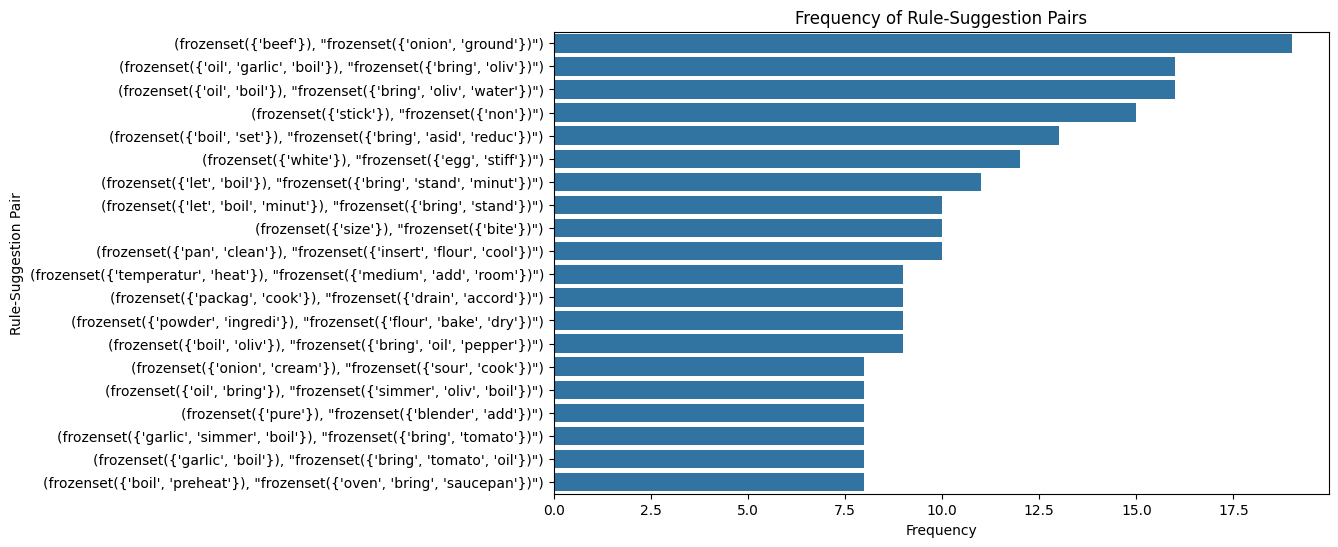

In [38]:
_,_,lift_suggestions = zip(*lift_results)

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Flatten the list to get all rule-suggestion pairs
rule_suggestion_pairs = []
for _, rule_dict in lift_suggestions:
    for rule, (suggestion, _) in rule_dict.items():
        rule_suggestion_pairs.append((rule, suggestion))

# Step 2: Count frequencies of each pair
frequency_counter = Counter(rule_suggestion_pairs)

# Step 3: Find the most common pairs
most_common_pairs = frequency_counter.most_common(20)  # You can also specify a number like most_common(10)

# Preparing DataFrame for Seaborn
data = {
    "Rule-Suggestion Pair": [f"{pair}" for pair, count in most_common_pairs],
    "Count": [count for pair, count in most_common_pairs]
}
df = pd.DataFrame(data)

# Creating the plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Count", y="Rule-Suggestion Pair", data=df.sort_values(by="Count", ascending=False))
plt.title("Frequency of Rule-Suggestion Pairs")
plt.xlabel("Frequency")
plt.ylabel("Rule-Suggestion Pair")
plt.show()

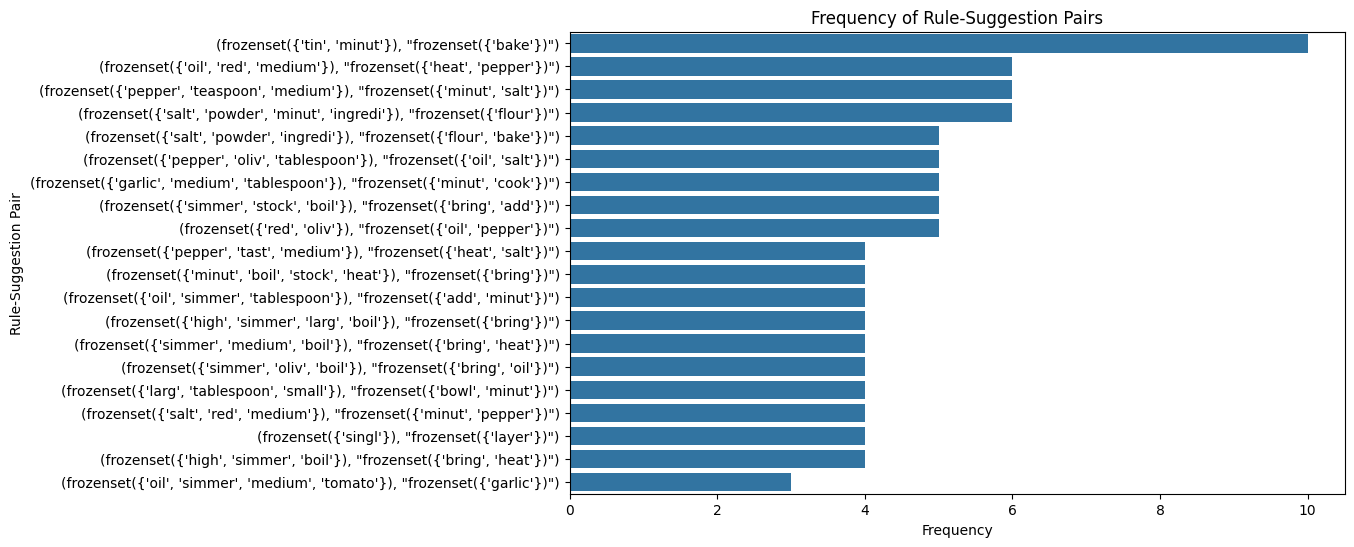

In [39]:
_,_,lift_suggestions = zip(*confidence_results)

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Flatten the list to get all rule-suggestion pairs
rule_suggestion_pairs = []
for _, rule_dict in lift_suggestions:
    for rule, (suggestion, _) in rule_dict.items():
        rule_suggestion_pairs.append((rule, suggestion))

# Step 2: Count frequencies of each pair
frequency_counter = Counter(rule_suggestion_pairs)

# Step 3: Find the most common pairs
most_common_pairs = frequency_counter.most_common(20)  # You can also specify a number like most_common(10)

# Preparing DataFrame for Seaborn
data = {
    "Rule-Suggestion Pair": [f"{pair}" for pair, count in most_common_pairs],
    "Count": [count for pair, count in most_common_pairs]
}
df = pd.DataFrame(data)

# Creating the plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Count", y="Rule-Suggestion Pair", data=df.sort_values(by="Count", ascending=False))
plt.title("Frequency of Rule-Suggestion Pairs")
plt.xlabel("Frequency")
plt.ylabel("Rule-Suggestion Pair")
plt.show()

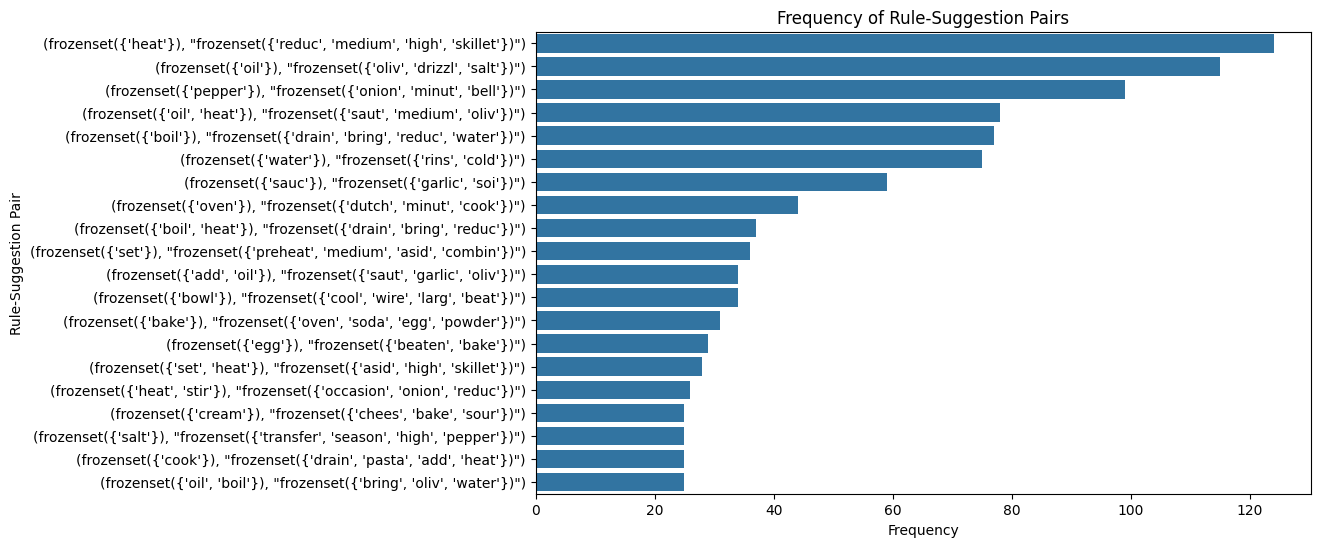

In [40]:
_,_,lift_suggestions = zip(*zhangs_metric_results)

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Flatten the list to get all rule-suggestion pairs
rule_suggestion_pairs = []
for _, rule_dict in lift_suggestions:
    for rule, (suggestion, _) in rule_dict.items():
        rule_suggestion_pairs.append((rule, suggestion))

# Step 2: Count frequencies of each pair
frequency_counter = Counter(rule_suggestion_pairs)

# Step 3: Find the most common pairs
most_common_pairs = frequency_counter.most_common(20)  # You can also specify a number like most_common(10)

# Preparing DataFrame for Seaborn
data = {
    "Rule-Suggestion Pair": [f"{pair}" for pair, count in most_common_pairs],
    "Count": [count for pair, count in most_common_pairs]
}
df = pd.DataFrame(data)

# Creating the plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Count", y="Rule-Suggestion Pair", data=df.sort_values(by="Count", ascending=False))
plt.title("Frequency of Rule-Suggestion Pairs")
plt.xlabel("Frequency")
plt.ylabel("Rule-Suggestion Pair")
plt.show()

<hr color="#f0c6c6"/>
<h3><font color="#f0c6c6">Visualizations for Recipe NLG</font></h3>

<hr color="#f0c6c6"/>

###

In [6]:
# Move onto sample recipes
import pickle
with open(f'{DATA_DIR}/sample_recipe_rules_per_metric.pkl', 'rb') as f:
    sample_recipes = pickle.load(f)

In [7]:
import numpy as np


lift_results = sample_recipes[0]
confidence_results = sample_recipes[1]
zhangs_metric_results = sample_recipes[2]

assert np.all([
    result[1] == 'lift' for result in lift_results
]) and np.all([
    result[1] == 'confidence' for result in confidence_results
]) and np.all([
    result[1] == 'zhangs_metric' for result in zhangs_metric_results
])

In [12]:
sample_recipes.loc[619506]

Unnamed: 0                                                      619506
title                                                      Baked Beans
ingredients          ["1 lb. ground beef", "1 small onion, chopped"...
directions           [Brown ground beef and onion in heavy skillet,...
link                   www.cookbooks.com/Recipe-Details.aspx?id=202520
source                                                        Gathered
NER                  ["ground beef", "onion", "salt", "pepper", "vi...
directions_length                                                  280
preprocessed         [brown, ground, beef, onion, heavi, skillet, c...
Name: 619506, dtype: object

In [8]:
lift_results[0]

(619506,
 'lift',
 ({frozenset({'bake', 'high'}),
   frozenset({'bake', 'cook', 'heat'}),
   frozenset({'bake', 'heat', 'onion'}),
   frozenset({'bake', 'heat', 'stir'}),
   frozenset({'remain', 'skillet'}),
   frozenset({'cook', 'skillet'}),
   frozenset({'add', 'bake', 'ingredi'}),
   frozenset({'add', 'cook', 'drain'}),
   frozenset({'bake', 'skillet'}),
   frozenset({'cook', 'heat', 'skillet'})},
  {frozenset({'bake', 'heat', 'onion'}): ("frozenset({'oven', 'skillet'})",
    10.092780084012546),
   frozenset({'bake', 'skillet'}): ("frozenset({'preheat', 'heat', 'pepper'})",
    9.00164064673164),
   frozenset({'add', 'bake', 'ingredi'}): ("frozenset({'vanilla', 'dry'})",
    8.791885517504303),
   frozenset({'remain',
              'skillet'}): ("frozenset({'heat', 'larg', 'tablespoon'})", 8.67808718245253),
   frozenset({'add', 'cook', 'drain'}): ("frozenset({'pasta', 'water'})",
    8.620928517228425),
   frozenset({'bake', 'cook', 'heat'}): ("frozenset({'preheat', 'skillet'})",
